# Generative Image to Image Translation with CycleGAN  
[Parag K. Mital](https://pkmital.com)  
[Creative Applications of Deep Learning](https://www.kadenze.com/programs/creative-applications-of-deep-learning-with-tensorflow)  
[Kadenze, Inc.](https://kadenze.com)  

This content appears as part of the course, [Creative Applications of Deep Learning](https://www.kadenze.com/programs/creative-applications-of-deep-learning-with-tensorflow), as part of the [Kadenze Academy](https://kadenze.com) program.  This content is licensed under an [APL 2.0 License](https://github.com/pkmital/CycleGAN/blob/master/LICENSE).

In [2]:
!git clone https://github.com/pkmital/CycleGAN.git

fatal: destination path 'CycleGAN' already exists and is not an empty directory.


# Introduction

This colab introduces you to the following work:

(-0.5, 1773.5, 1345.5, -0.5)

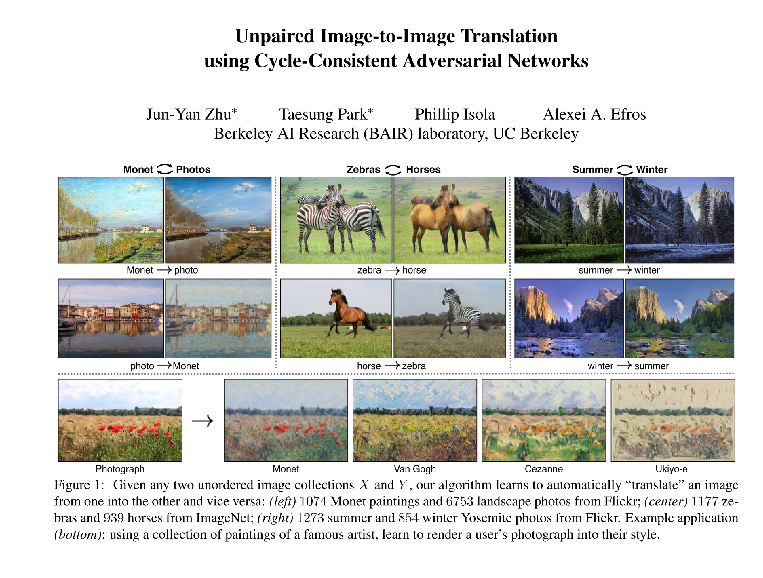

In [3]:
%matplotlib inline
import matplotlib
plt = matplotlib.pyplot
plt.figure(figsize=(20,10))
plt.imshow(plt.imread('CycleGAN/imgs/cycle-gan-paper.png'))
plt.axis('off')

Image to image translation covers a very wide set of applications in computer graphics, computer vision, and deep learning with image and video.  The basic idea is to translate an input image into an output image.  This is different to say autoencoding an image, where both the input and the output are exactly the same.  In this case, they are expected to be different sets of images.  For instance, the input image might be a landscape photo and the output could be an artistic stylization of that photo.  Or perhaps the input is a photo of a horse, and the output should be photos of zebras instead.  Let's say instead you have a maps showing the outlines of streets and highways, and you'd like to apply a texture to these images so that it looks like a satellite image instead.  Or maybe you want to recreate the Google AI Experiment where they convert sketches to pictures of cats.  Or perhaps you want to recreate the app FaceApp which adds smiles to people's faces.  These are all examples of image to image translation. 

One of the earliest demonstrations of this idea is in a paper in 2001 called Image Analogies.  Aaron Hertzmann and colleagues showed the basic idea of image to image translation by using analogous image pairs.  You would give an example analogy, such as an image of a street map, and the corresponding satellite image, and then you could give it any other street map image, and it would give you a new satellite image for it.

(-0.5, 1885.5, 803.5, -0.5)

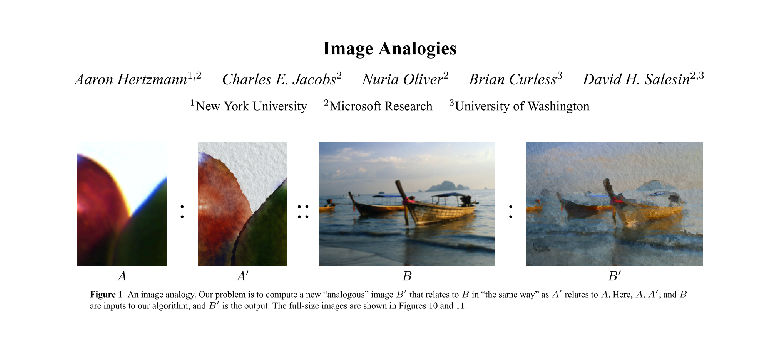

In [4]:
plt.figure(figsize=(13,10))
plt.imshow(plt.imread('CycleGAN/imgs/image-analogies-paper.png'))
plt.axis('off')

How could we build a neural network to do something similar?  Autoencoders and generative adversarial networks allow for some pretty impressive unsupervised modeling of image collections.  For instance, an autoencoder with an input different from the output could essentially learn to translate one image into another.  Let's say for instance if you had black and white images, and wanted to convert them to color images, you could create a dataset of either image, and then feed in pairs of each type of image to an autoencoder.  The resulting loss function would then take as output some color image, and input a black and white image, and the network would need to learn to essentially colorize the image.

Though if you've ever tried this, you might have found that autoencoders generally have a pretty big issue with images: their loss function generally uses a L2 or squared loss function, and this often results in really blurry reconstructions, or reconstructions that don't necessarily understand the content of the image beyond simple pixels.  

We then saw that the generative adversarial network did not have this issue since it learned its own loss function by training a separate network, a discriminator, to say whether an image was real or fake.   So could we build a generative adversarial network that could learn to colorize an image?  Or to convert street maps into satellite maps?  Or any other potential application of image to image translation?  This tutorial covers one of the state of the art techniques for image to image translation called CycleGAN.

# CycleGAN

CycleGAN builds on earlier work called Pix2Pix.  The Pix2Pix network requires paired translations, which means that while training, for each input, you need to specify exactly what the output should look like.  CycleGAN instead just requires two _unpaired_ collections of images and will do its best to find the mapping between them, without you having to specify what the pairs are.  It's a really impressive network and pretty simple to build.  We'll need many of the same components that we needed for the DCGAN and VAEGAN networks we built in Course 1 Session 5.

(-0.5, 879.5, 827.5, -0.5)

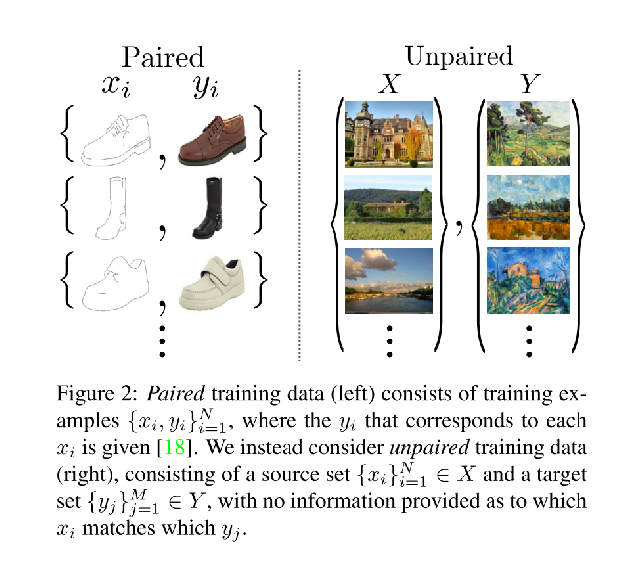

In [5]:
plt.figure(figsize=(13,10))
plt.imshow(plt.imread('CycleGAN/imgs/cycle-gan-figure-2.png'))
plt.axis('off')


We're going to need to build a set of operations that map one image collection to another, and build those operations for each image collection $X$ and $Y$.  We'll also have to build another set of operations so that there is a complete cycle of operations that attempt to map our first collection of images, $X$, to the second collection, $Y$, so a fake $Y$ which we denote mathematically by $\hat{Y}$, and then another generator to map both the real $Y$ and the fake $\hat{Y}$ back to $\hat{X}$ again. In the Figure below, we can sort of see how this works graphically with two collections, $X$ and $Y$:


(-0.5, 1793.5, 705.5, -0.5)

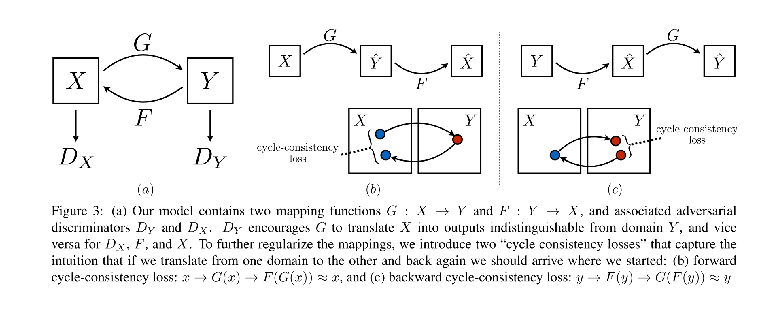

In [6]:
plt.figure(figsize=(13,10))
plt.imshow(plt.imread('CycleGAN/imgs/cycle-gan-figure-3.png'))
plt.axis('off')

# Quiz:

> How many generative networks are in the CycleGAN network?

> How many discriminators are in the CycleGAN network?

# Encoder

This network essentially trains 2 autoencoders using a set of 2 generators (`G` and `F` in the images above) and 2 discriminators (`D_X` and `D_Y` in the images above) .  The idea is pretty easy to grasp if you are already familiar with generative adversarial networks, and most of the tricky bits are in the details of implementation.

The Generator is slightly different though.  Instead of starting with a random feature vector of say 100 values, we'll actually start with an image and then compose something not unlike an Autoencoder.  The structure of this Autoencoder is a little different.  We'll have three major components: an encoder, transformer, and decoder. 

The encoder is composed of a few convolutional layers with stride 2 which will downsample the image with each layer.  The authors create it with 3 layers, and use padding on the first layer.

Let's see it written up as code.  First some imports.  We'll include TensorFlow as well as a contrib package which makes writing layers a lot easier, similar to Keras.  We'll also be using Instance Normalization (http://arxiv.org/abs/1607.08022) for our layer normalization and Leaky ReLus as the authors of CycleGAN have done.  I've included my implementation of CycleGAN and all utility functions in the `cycle_gan.py` module which you can also find as part of the `cadl` repo: https://github.com/pkmital/pycadl (easily pip installed by: `pip install cadl`):

In [0]:

# !pip install scipy==0.19.1
# !pip install cadl
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as tfl
from cadl.cycle_gan import lrelu, instance_norm

Now let's write a function for the encoder, following the CycleGAN architecture.  We want a padding layer, then 3 convolutional layers with strides 1, then 2, then another 2.  The first convolutional layer will have a 7x7 convolution, and the rest will be 3x3.  Also, we'll initialize the weights to a standard deviation of 0.02 using a normal distribution.  For an activation function, we'll be using a Leaky ReLu with 0.2 leakage.  We'll also exponentially increase the number of filters with each layer, starting with 32, then going to 64 and finally 128.  Lastly, we'll also use something like batch normalization called instance normalization, and use the TensorFlow layers module to do the entire convolution operation for us in a single convenient function:

In [0]:
def encoder(x, n_filters=32, k_size=3, normalizer_fn=instance_norm,
        activation_fn=lrelu, scope=None, reuse=None):
    with tf.variable_scope(scope or 'encoder', reuse=reuse):
        h = tf.pad(x, [[0, 0], [k_size, k_size], [k_size, k_size], [0, 0]],
                "REFLECT")
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters,
                kernel_size=7,
                stride=1,
                padding='VALID',
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                activation_fn=activation_fn,
                scope='1',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters * 2,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                activation_fn=activation_fn,
                scope='2',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters * 4,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                activation_fn=activation_fn,
                scope='3',
                reuse=reuse)
    return h

We're also being explicit about our scope and reuse as we'll need to reuse these variables a few times which we'll see in a few moments.

# Residual Blocks and Transformer

The next part of the Generator is the Transformer.  These are going to be 6 or 9 Residual Blocks, which is a really powerful module that comes up a lot in almost every new architecture out there.  Instead of simply having a convolutional layer, we'll have a convolutional layer and then sum together the original output.  So it's a sort of residual function of the input which should be learned, residual meaning what's left over.  The residual blocks allow the base activation to persist, but then learns a simple addition on top of that layer.  This is useful because it ensures the original activation has a path to the output.  And similarly, it is useful for backpropagation since the gradient has less chance of exploding or vanishing, as they typically can do in very deep networks.  To read more about residual networks, check the original paper which shows how to create a network of 1000s of layers, all without having issues with vanishing or exploding gradients!

Alright let's code up the residual block.  All the convolutions are going to be single stride, and 128 channels.  Each block will have a pad layer, a 3x3 convolution with Leaky ReLu and Instance Normalization, another pad layer, another convolution with Instance Normalization, except no nonlinearity, and then an addition with the starting activation.

In [0]:
def residual_block(x, n_channels=128, normalizer_fn=instance_norm,
        activation_fn=lrelu, kernel_size=3, scope=None, reuse=None):
    with tf.variable_scope(scope or 'residual', reuse=reuse):
        h = tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_channels,
                kernel_size=kernel_size,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                padding='VALID',
                activation_fn=activation_fn,
                scope='1',
                reuse=reuse)
        h = tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_channels,
                kernel_size=kernel_size,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                padding='VALID',
                activation_fn=None,
                scope='2',
                reuse=reuse)
        h = tf.add(x, h)
    return h

Now we can compose many residual blocks to create our Transformer:

In [0]:
def transform(x, img_size=256, reuse=None):
    h = x
    if img_size >= 256:
        n_blocks = 9
    else:
        n_blocks = 6
    for block_i in range(n_blocks):
        with tf.variable_scope('block_{}'.format(block_i), reuse=reuse):
            h = residual_block(h, reuse=reuse)
    return h

# Decoder

Great, now the last piece we need to code up our Generator is the Decoder.  This is basically going to do the complete opposite of our Encoder.  We'll have three deconvolutional layers with stride 2, stride 2, and stride 1, and kernel sizes 3, 3, and 7.  Before the last layer we'll also pad to avoid boundary artifacts with the larger 7x7 kernel, and our last activation will be a tanh, meaning our images will be in the range of -1 and 1.  Generally this is an ideal normalization for images as it means the starting point is basically a grey image.  We'll need to keep this in mind when we feed our data into the network and ensure we are using images in the same range.

In [0]:
def decoder(x, n_filters=32, k_size=3, normalizer_fn=instance_norm,
        activation_fn=lrelu, scope=None, reuse=None):
    with tf.variable_scope(scope or 'decoder', reuse=reuse):
        h = tfl.conv2d_transpose(
                inputs=x,
                num_outputs=n_filters * 2,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                activation_fn=activation_fn,
                scope='1',
                reuse=reuse)
        h = tfl.conv2d_transpose(
                inputs=h,
                num_outputs=n_filters,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                activation_fn=activation_fn,
                scope='2',
                reuse=reuse)
        h = tf.pad(h, [[0, 0], [k_size, k_size], [k_size, k_size], [0, 0]],
                "REFLECT")
        h = tfl.conv2d(
                inputs=h,
                num_outputs=3,
                kernel_size=7,
                stride=1,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                padding='VALID',
                normalizer_fn=normalizer_fn,
                activation_fn=tf.nn.tanh,
                scope='3',
                reuse=reuse)
    return h

Putting it all together, our Generator will first encode, then transform, and then finally decode like so:

In [0]:
def generator(x, scope=None, reuse=None):
    img_size = x.get_shape().as_list()[1]
    with tf.variable_scope(scope or 'generator', reuse=reuse):
        h = encoder(x, reuse=reuse)
        h = transform(h, img_size, reuse=reuse)
        h = decoder(h, reuse=reuse)
    return h

# PatchGAN, Receptive Field Sizes, and the Discriminator

The other major component is the Discriminator.  This network will take as input an image and then output a single value.  In the case of a true image, it should output 1, and in the case of a false image, it should output 0.  For the generator, we want the opposite to be true.  In any case, the discriminator should saturate at 0 or 1, so will need a sigmoid as its final activation.  The network will take as input a 256 x 256 pixel image and use a series of 5 convolutional layers not unlike the ones we've already used.  The first three layers will be stride 2, and then the last 2 will be stride 1.  We'll increase the number of outputs exponentially until the last layer which will have a single channel as output.

Unlike a typical GAN, what we're creating is what the Pix2Pix and CycleGAN authors call a PatchGAN discriminator.  This network doesn't actually reduce down the image to a single value, but instead will reduce down the 256 x 256 pixel image to a spatial map with 1 channel as output.  The resulting map effectively has individual discriminators which we average together to get the final result.  The authors show a few possible combinations of stride and layer sizes to get effectively different receptive field sizes in the final layer, and show that this combination of 5 layers seems to have the best performance and a receptive field size of 70.

Let's break it down a bit more and see how they come up with a receptive field size of 70:

(-0.5, 2145.5, 1511.5, -0.5)

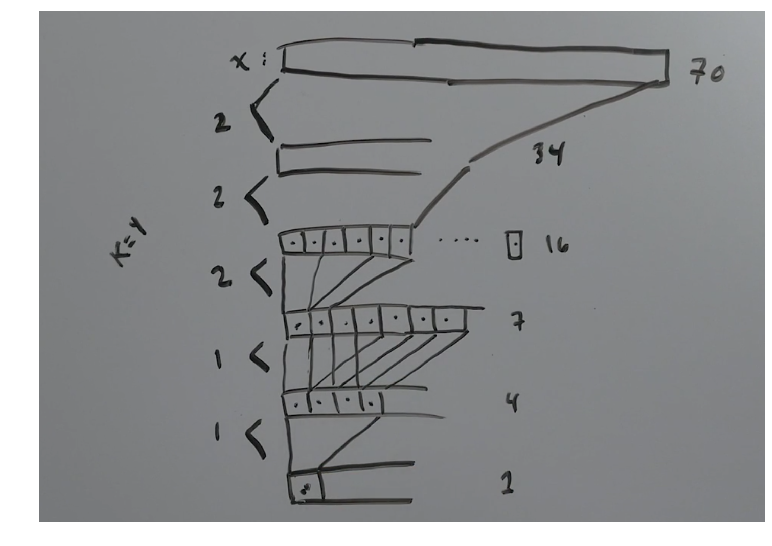

In [13]:
plt.figure(figsize=(13,10))
plt.imshow(plt.imread('CycleGAN/imgs/receptive-field-sizes.png'))
plt.axis('off')

In the image above, we can see the input layer at the top, and the final layer at the bottom.  Working form the final layer back to the top, we can see how 1 neuron contributes to an increasing number of neurons in preceding layers.  The receptive field for each layer for a single neuron in the last layer is written in the right margin: [1, 4, 7, 16, 34, 70]

The code for the discriminator looks like so:

In [0]:
def discriminator(x, n_filters=64, k_size=4, activation_fn=lrelu,
        normalizer_fn=instance_norm, scope=None, reuse=None):
    with tf.variable_scope(scope or 'discriminator', reuse=reuse):
        h = tfl.conv2d(
                inputs=x,
                num_outputs=n_filters,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                activation_fn=activation_fn,
                normalizer_fn=None,
                scope='1',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters * 2,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                activation_fn=activation_fn,
                normalizer_fn=normalizer_fn,
                scope='2',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters * 4,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                activation_fn=activation_fn,
                normalizer_fn=normalizer_fn,
                scope='3',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters * 8,
                kernel_size=k_size,
                stride=1,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                activation_fn=activation_fn,
                normalizer_fn=normalizer_fn,
                scope='4',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=1,
                kernel_size=k_size,
                stride=1,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                activation_fn=tf.nn.sigmoid,
                scope='5',
                reuse=reuse)
        return h

# Connecting the Pieces

Now we've got all the major components we need to create a CycleGAN.  We just need to connect them up using a few placeholders, create our loss functions, and finally build our training method.  Let's start with our placeholders.

We'll start with placeholders for each of the two collections which I'll call `X` and `Y`:

In [0]:
img_size = 256
X_real = tf.placeholder(name='X', shape=[1, img_size, img_size, 3], dtype=tf.float32)
Y_real = tf.placeholder(name='Y', shape=[1, img_size, img_size, 3], dtype=tf.float32)

To get the "fake" outputs of these "real" inputs, we give them to a corresponding generator.  We'll have one generator for each direction that we'd like to go in.  One which converts the X style to a Y style, and vice-versa.

In [16]:
X_fake = generator(Y_real, scope='G_yx')
Y_fake = generator(X_real, scope='G_xy')

W0905 19:42:46.815819 140608255637376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/cadl/cycle_gan.py:105: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0905 19:42:46.825660 140608255637376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/cadl/cycle_gan.py:107: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0905 19:42:46.841401 140608255637376 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/cadl/cycle_gan.py:115: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Because this is a CycleGAN, we'll enforce an additional constraint on the generated output to match the original image quality with an L1-Loss.  This will effectively test both generators by generating from X to Y and then back to X again. Similarly, for Y, we'll generate to X, and again to Y.  To get these images, we simple reuse the existing generators and create the cycle images:

In [0]:
X_cycle = generator(Y_fake, scope='G_yx', reuse=True)
Y_cycle = generator(X_fake, scope='G_xy', reuse=True)

Our discriminators will then act on the `real` and `fake` images like so:

In [0]:
D_X_real = discriminator(X_real, scope='D_X')
D_Y_real = discriminator(Y_real, scope='D_Y')
D_X_fake = discriminator(X_fake, scope='D_X', reuse=True)
D_Y_fake = discriminator(Y_fake, scope='D_Y', reuse=True)

To create our generator's loss, we'll compute the L1 distance between the `cycle` and `real` images, and test how well the generator "fools" the discriminator:

In [0]:
l1 = 10.0
loss_cycle = tf.reduce_mean(l1 * tf.abs(X_real - X_cycle)) + \
             tf.reduce_mean(l1 * tf.abs(Y_real - Y_cycle))
loss_G_xy = tf.reduce_mean(tf.square(D_Y_fake - 1.0)) + loss_cycle
loss_G_yx = tf.reduce_mean(tf.square(D_X_fake - 1.0)) + loss_cycle

The authors suggest to use a constant weighting on the L1 cycle loss of 10.0.

Finally, we'll need to compute the loss for our discriminators.  Unlike the generators which use the current generation of fake images, we'll actually use a history buffer of generated images, and randomly sample a generated image from this history buffer.  Previous work on GANs has shown this can help training and the CycleGAN authors suggest using it as well.  We'll take care of keeping track of this history buffer on the CPU side of things and create a placeholder for the TensorFlow graph to help send the history image into the graph:

In [0]:
X_fake_sample = tf.placeholder(name='X_fake_sample',
        shape=[None, img_size, img_size, 3], dtype=tf.float32)
Y_fake_sample = tf.placeholder(name='Y_fake_sample',
        shape=[None, img_size, img_size, 3], dtype=tf.float32)

Now we'll ask the discriminator to assess these images:

In [0]:
D_X_fake_sample = discriminator(X_fake_sample, scope='D_X', reuse=True)
D_Y_fake_sample = discriminator(Y_fake_sample, scope='D_Y', reuse=True)

And now we can create our loss for the discriminator.  Unlike the original GAN implementation, we use a square loss instead of binary cross entropy loss.  This turns out to be a bit less prone to errors:

In [0]:
loss_D_Y = (tf.reduce_mean(tf.square(D_Y_real - 1.0)) + \
            tf.reduce_mean(tf.square(D_Y_fake_sample))) / 2.0
loss_D_X = (tf.reduce_mean(tf.square(D_X_real - 1.0)) + \
            tf.reduce_mean(tf.square(D_X_fake_sample))) / 2.0

# Optimizer

Let's now take a look at how to build optimizers for such a model.  I've wrapped everything we've just done into a convenient module called `cycle_gan`.  We can create the entire network like so:

In [23]:
tf.reset_default_graph()
from cadl.cycle_gan import cycle_gan
net = cycle_gan(img_size=img_size)

W0905 19:42:50.502003 140608255637376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/cadl/cycle_gan.py:453: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0905 19:42:53.712307 140608255637376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/cadl/cycle_gan.py:62: The name tf.squared_difference is deprecated. Please use tf.math.squared_difference instead.

W0905 19:42:53.731268 140608255637376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/cadl/cycle_gan.py:491: The name tf.summary.histogram is deprecated. Please use tf.compat.v1.summary.histogram instead.

W0905 19:42:53.741266 140608255637376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/cadl/cycle_gan.py:497: The name tf.summary.image is deprecated. Please use tf.compat.v1.summary.image instead.

W0905 19:42:53.757482 140608255637376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-pac

This will return the entire network in a dict for us:

In [24]:
list(net.items())

[('G_vars',
  [<tf.Variable 'G_xy/encoder/1/Conv/weights:0' shape=(7, 7, 3, 32) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/1/instance_norm/scale:0' shape=(32,) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/1/instance_norm/offset:0' shape=(32,) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/2/Conv/weights:0' shape=(3, 3, 32, 64) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/2/instance_norm/scale:0' shape=(64,) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/2/instance_norm/offset:0' shape=(64,) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/3/Conv/weights:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/3/instance_norm/scale:0' shape=(128,) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/3/instance_norm/offset:0' shape=(128,) dtype=float32_ref>,
   <tf.Variable 'G_xy/block_0/residual/1/Conv/weights:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
   <tf.Variable 'G_xy/block_0/residual/1/instance_norm/scale:0' shape=(128,) dtype=float32_ref

Just like in the original GAN implementation, we'll create individual optimizers which can only update certain parts of the network.  The original GAN had two optimizers, one for the generator and one for the discriminator.  Even though the discriminator depends on input from the generator, we would only optimize the variables belonging to the discriminator when training the discriminator.  If we did not do this, we'd be making the generator *worse*, when what we really want to happen is for both networks to get better.  We'll do the same thing here, except now we actually have 3 networks to optimize, and so we'll need 3 optimizers: `G_xy` and `G_yx` variables will be optimized as the generator, while `D_X`, and `D_Y`, should update two different discriminators.

First let's get the variables:

In [0]:
training_vars = tf.trainable_variables()
D_X_vars = [v for v in training_vars if v.name.startswith('D_X')]
D_Y_vars = [v for v in training_vars if v.name.startswith('D_Y')]
G_xy_vars = [v for v in training_vars if v.name.startswith('G_xy')]
G_yx_vars = [v for v in training_vars if v.name.startswith('G_yx')]
G_vars = G_xy_vars + G_yx_vars

And then build the optimizers:

In [26]:
learning_rate = 0.001
D_X = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(
        net['loss_D_X'], var_list=D_X_vars)
D_Y = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(
        net['loss_D_Y'], var_list=D_Y_vars)
G = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(
        net['loss_G'], var_list=G_vars)

W0905 19:42:54.089387 140608255637376 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Note that we concatenated both generators into one variable list:

In [27]:
print(G)

name: "Adam_2"
op: "NoOp"
input: "^Adam_2/update_G_xy/encoder/1/Conv/weights/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/1/instance_norm/scale/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/1/instance_norm/offset/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/2/Conv/weights/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/2/instance_norm/scale/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/2/instance_norm/offset/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/3/Conv/weights/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/3/instance_norm/scale/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/3/instance_norm/offset/ApplyAdam"
input: "^Adam_2/update_G_xy/block_0/residual/1/Conv/weights/ApplyAdam"
input: "^Adam_2/update_G_xy/block_0/residual/1/instance_norm/scale/ApplyAdam"
input: "^Adam_2/update_G_xy/block_0/residual/1/instance_norm/offset/ApplyAdam"
input: "^Adam_2/update_G_xy/block_0/residual/2/Conv/weights/ApplyAdam"
input: "^Adam_2/update_G_xy/block_0/residual/2/instance_norm/scale/Apply

As part of the discriminator training, we test how it classifies real images and generated images.  For the generated images, the discriminator takes a randomly generated image from the last 50 some generated images.  This is to make the training a bit more stable, according to: Shrivastava, A., Pfister, T., Tuzel, O., Susskind, J., Wang, W., & Webb, R. (2016). Learning from Simulated and Unsupervised Images through Adversarial Training. Retrieved from http://arxiv.org/abs/1612.07828 - see Section 2.3 for details.  The idea here is the discriminator should still be able to say that older generated images are fake.  It may be the case that the generator just re-learns things the discriminator has forgotten about, and this might help with making things more stable.

To set this up, we determine our `capacity`, such as 50 images, and create a list of images all initialized to 0:

In [0]:
# How many fake generations to keep around
capacity = 50

# Storage for fake generations
fake_Xs = capacity * [np.zeros((1, img_size, img_size, 3), dtype=np.float32)]
fake_Ys = capacity * [np.zeros((1, img_size, img_size, 3), dtype=np.float32)]

# Batch Generator

Finally, we're almost ready to train.  We just need data!  The most important part!  I've included two kinds of batch generators to help you get data into your CycleGAN network.  One takes your X and Y image collections as arrays.  The other takes a single image for X and Y and will randomly crop it.  I've successfully used this network with very large images, including Hieronymous Bosch's Garden of Earthly Delights.  The first collection was a sketch rendering, and the second was a high resolution image.

In [0]:
from cadl.cycle_gan import batch_generator_dataset, batch_generator_random_crop

In [30]:
img_size


256

In [32]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving style256.JPG to style256.JPG
Saving image256.JPG to image256.JPG
User uploaded file "style256.JPG" with length 18136 bytes
User uploaded file "image256.JPG" with length 16634 bytes


In [0]:
import cv2

In [0]:
style1 = cv2.imread("image256.JPG")
image1 = cv2.imread("style256.JPG")

To use the dataset generator, feed in two arrays images shaped: `N` x `H` x `W` x 3:

In [0]:
# Load your data into imgs1 and imgs2 here!
# I've loaded in random noise as an example, but you'll want to use
# plt.imread or skimage to load in images into a list of images
ds_X, ds_Y = np.expand_dims(image1, 0), \
             np.expand_dims(style1, 0)

Now you can get batches into your CycleGAN network using the `batch_generator_dataset` function:

In [54]:

X_i, Y_i = next(batch_generator_dataset(ds_X, ds_Y))
X_i.shape, Y_i.shape

((1, 256, 256, 3), (1, 256, 256, 3))

Alternatively, you can grab random crops of a larger image using the `batch_generator_random_crop` function and feed these into your network instead.  You'll want to set the `min_size` and `max_size` parameters to determine what can be cropped and what the crop should be reshaped to.

In [0]:
# ds_X, ds_Y = np.random.rand(1024, 1024, 3), np.random.rand(1024, 1024, 3)
# X_i, Y_i = next(batch_generator_random_crop(
#         ds_X, ds_Y, min_size=img_size, max_size=512))
# X_i.shape, Y_i.shape

In [55]:
cd content


[Errno 2] No such file or directory: 'content'
/content/CycleGAN


In [37]:
cd CycleGAN

/content/CycleGAN


In [0]:
import os

# Training

The CADL `cycle_gan` module includes a train function.  But if you're curious to know the details of training, I've commented the code below:

In [0]:
idx = 0
it_i = 0
n_epochs = 250
ckpt_path = './'

In [57]:
# # Train
# with tf.Session() as sess:
#     # Build an init op for our variables
#     init_op = tf.group(tf.global_variables_initializer(),
#                        tf.local_variables_initializer())
#     sess.run(init_op)
    
#     # We'll also save our model so we can load it up again
#     saver = tf.train.Saver()
#     writer = tf.summary.FileWriter(ckpt_path)
    
#     for epoch_i in range(n_epochs):
#         # You'll want to use the approriate batch generator here!
#         for X, Y in next(batch_generator_dataset(ds_X, ds_Y)):

#             # First generate in both directions
#             X_fake, Y_fake = sess.run(
#                 [net['X_fake'], net['Y_fake']],
#                 feed_dict={net['X_real']: X,
#                            net['Y_real']: Y})

#             # Now sample from history
#             if it_i < capacity:
#                 # Not enough samples yet, fill up history buffer
#                 fake_Xs[idx] = X_fake
#                 fake_Ys[idx] = Y_fake
#                 idx = (idx + 1) % capacity
#             elif np.random.random() > 0.5:
#                 # Swap out a random idx from history
#                 rand_idx = np.random.randint(0, capacity)
#                 fake_Xs[rand_idx], X_fake = X_fake, fake_Xs[rand_idx]
#                 fake_Ys[rand_idx], Y_fake = Y_fake, fake_Ys[rand_idx]
#             else:
#                 # Use current generation
#                 pass

#             # Optimize G Networks
#             loss_G = sess.run(
#                 [net['loss_G'], G],
#                 feed_dict={
#                     net['X_real']: X,
#                     net['Y_real']: Y,
#                     net['Y_fake_sample']: Y_fake,
#                     net['X_fake_sample']: X_fake
#                 })[0]

#             # Optimize D_Y
#             loss_D_Y = sess.run(
#                 [net['loss_D_Y'], D_Y],
#                 feed_dict={
#                     net['X_real']: X,
#                     net['Y_real']: Y,
#                     net['Y_fake_sample']: Y_fake
#                 })[0]

#             # Optimize D_X
#             loss_D_X = sess.run(
#                 [net['loss_D_X'], D_X],
#                 feed_dict={
#                     net['X_real']: X,
#                     net['Y_real']: Y,
#                     net['X_fake_sample']: X_fake
#                 })[0]

#             print(it_i, 'G:', loss_G, 'D_X:', loss_D_X, 'D_Y:', loss_D_Y)

#             # Update summaries
#             if it_i % 100 == 0:
#                 summary = sess.run(
#                     net['summaries'],
#                     feed_dict={
#                         net['X_real']: X,
#                         net['Y_real']: Y,
#                         net['X_fake_sample']: X_fake,
#                         net['Y_fake_sample']: Y_fake
#                     })
#                 writer.add_summary(summary, it_i)
#             it_i += 1

#         # Save
#         if epoch_i % 50 == 0:
#             saver.save(
#                 sess,
#                 os.path.join(ckpt_path, 'model.ckpt'),
#                 global_step=epoch_i)
            
#         # Show generative images:        
#         fig, axs = plt.subplots(2, 2, figsize=(10, 10))
#         axs[0][0].set_title('X Real')
#         axs[0][0].imshow(np.clip(X[0], 0.0, 1.0))
#         axs[0][1].set_title('X Fake')
#         axs[0][1].imshow(np.clip(X_fake[0], 0.0, 1.0))
#         axs[1][0].set_title('Y')
#         axs[1][0].imshow(np.clip(Y[0], 0.0, 1.0))
#         axs[1][1].set_title('Y Fake')
#         axs[1][1].imshow(np.clip(Y_fake[0], 0.0, 1.0))
#         fig.show()

ValueError: ignored

In [0]:
# Train-------------------------------------------------------------------------------------------------------------------
with tf.Session() as sess:
    # Build an init op for our variables
    init_op = tf.group(tf.global_variables_initializer(),
                       tf.local_variables_initializer())
    sess.run(init_op)
    
    # We'll also save our model so we can load it up again
    saver = tf.train.Saver()
    writer = tf.summary.FileWriter(ckpt_path)
    
    for epoch_i in range(n_epochs):
        # You'll want to use the approriate batch generator here!
        X, Y = next(batch_generator_dataset(ds_X, ds_Y))
       

        # First generate in both directions
        X_fake, Y_fake = sess.run(
            [net['X_fake'], net['Y_fake']],
            feed_dict={net['X_real']: X,
                       net['Y_real']: Y})

        # Now sample from history
        if it_i < capacity:
            # Not enough samples yet, fill up history buffer
            fake_Xs[idx] = X_fake
            fake_Ys[idx] = Y_fake
            idx = (idx + 1) % capacity
        elif np.random.random() > 0.5:
            # Swap out a random idx from history
            rand_idx = np.random.randint(0, capacity)
            fake_Xs[rand_idx], X_fake = X_fake, fake_Xs[rand_idx]
            fake_Ys[rand_idx], Y_fake = Y_fake, fake_Ys[rand_idx]
        else:
            # Use current generation
            pass

        # Optimize G Networks
        loss_G = sess.run(
            [net['loss_G'], G],
            feed_dict={
                net['X_real']: X,
                net['Y_real']: Y,
                net['Y_fake_sample']: Y_fake,
                net['X_fake_sample']: X_fake
            })[0]

        # Optimize D_Y
        loss_D_Y = sess.run(
            [net['loss_D_Y'], D_Y],
            feed_dict={
                net['X_real']: X,
                net['Y_real']: Y,
                net['Y_fake_sample']: Y_fake
            })[0]

        # Optimize D_X
        loss_D_X = sess.run(
            [net['loss_D_X'], D_X],
            feed_dict={
                net['X_real']: X,
                net['Y_real']: Y,
                net['X_fake_sample']: X_fake
            })[0]

        print(it_i, 'G:', loss_G, 'D_X:', loss_D_X, 'D_Y:', loss_D_Y)

        # Update summaries
        if it_i % 100 == 0:
            summary = sess.run(
                net['summaries'],
                feed_dict={
                    net['X_real']: X,
                    net['Y_real']: Y,
                    net['X_fake_sample']: X_fake,
                    net['Y_fake_sample']: Y_fake
                })
            writer.add_summary(summary, it_i)
        it_i += 1

        # Save
        if epoch_i % 50 == 0:
            saver.save(
                sess,
                os.path.join(ckpt_path, 'model.ckpt'),
                global_step=epoch_i)
            print("model checkpoint saved")
            
        # Show generative images:        
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))
        axs[0][0].set_title('X Real')
        axs[0][0].imshow(np.clip(X[0], 0.0, 1.0))
        axs[0][1].set_title('X Fake')
        axs[0][1].imshow(np.clip(X_fake[0], 0.0, 1.0))
        axs[1][0].set_title('Y')
        axs[1][0].imshow(np.clip(Y[0], 0.0, 1.0))
        axs[1][1].set_title('Y Fake')
        axs[1][1].imshow(np.clip(Y_fake[0], 0.0, 1.0))
        fig.show()

0 G: 2174.6099 D_X: 0.5807231 D_Y: 0.5844149
1 G: 2173.7754 D_X: 0.5975813 D_Y: 0.59480125
2 G: 2172.7715 D_X: 0.57282984 D_Y: 0.58152163
3 G: 2172.0364 D_X: 0.5673208 D_Y: 0.5468077
4 G: 2171.812 D_X: 0.5552828 D_Y: 0.54948354
5 G: 2171.602 D_X: 0.53269553 D_Y: 0.53170353
6 G: 2171.4001 D_X: 0.5221715 D_Y: 0.5284877
7 G: 2171.2388 D_X: 0.52287954 D_Y: 0.51867867
8 G: 2171.1062 D_X: 0.50852877 D_Y: 0.51039517
9 G: 2171.0237 D_X: 0.4972874 D_Y: 0.50533557
10 G: 2170.934 D_X: 0.4989654 D_Y: 0.49948132
11 G: 2170.852 D_X: 0.49518657 D_Y: 0.49444032
12 G: 2170.7905 D_X: 0.49018207 D_Y: 0.4906072
13 G: 2170.7346 D_X: 0.4870641 D_Y: 0.48833835
14 G: 2170.6846 D_X: 0.4850267 D_Y: 0.4840327
15 G: 2170.6396 D_X: 0.48469108 D_Y: 0.48116043
16 G: 2170.5955 D_X: 0.4815901 D_Y: 0.4786618
17 G: 2170.558 D_X: 0.48216894 D_Y: 0.47668248
18 G: 2170.524 D_X: 0.4797159 D_Y: 0.47547162
19 G: 2170.4854 D_X: 0.47893766 D_Y: 0.47400498
20 G: 2170.4463 D_X: 0.4772731 D_Y: 0.47305816


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


21 G: 2170.4075 D_X: 0.4767955 D_Y: 0.4723201
22 G: 2170.3782 D_X: 0.4766479 D_Y: 0.4716449
23 G: 2170.3447 D_X: 0.47556305 D_Y: 0.47100055
24 G: 2170.3174 D_X: 0.47537684 D_Y: 0.47029164
25 G: 2170.2925 D_X: 0.4748048 D_Y: 0.46963733
26 G: 2170.2651 D_X: 0.47390312 D_Y: 0.4689634
27 G: 2170.24 D_X: 0.47388178 D_Y: 0.4684623
28 G: 2170.2117 D_X: 0.4734251 D_Y: 0.4681534
29 G: 2170.1821 D_X: 0.47299147 D_Y: 0.4678589
30 G: 2170.1558 D_X: 0.4731613 D_Y: 0.4676807
31 G: 2170.1313 D_X: 0.4729083 D_Y: 0.4674512
32 G: 2170.107 D_X: 0.47281182 D_Y: 0.46728718
33 G: 2170.0903 D_X: 0.47214207 D_Y: 0.46708897
34 G: 2170.0686 D_X: 0.47307456 D_Y: 0.46673453
35 G: 2170.039 D_X: 0.47270072 D_Y: 0.46659732
36 G: 2170.016 D_X: 0.47246552 D_Y: 0.4664849
37 G: 2169.9917 D_X: 0.47217536 D_Y: 0.46635607
38 G: 2169.964 D_X: 0.47224155 D_Y: 0.46623808
39 G: 2169.9404 D_X: 0.47241452 D_Y: 0.46611398
40 G: 2169.918 D_X: 0.47228283 D_Y: 0.46594942
41 G: 2169.896 D_X: 0.47208256 D_Y: 0.46581635
42 G: 2169.874 

# Examples

Of course, training a CycleGAN on random data isn't nearly as fun as real data!  Here are a few example ideas to get you started:

## Tile/Terrain Generation

A classic image generation problem is turning labeled images into real life ones.  For instance, we may have a labeled image of a street scene depicting roads, sidewalks, lakes, etc... and want it to fill in all our low poly labels into a rich high resolution texture.  We can explore this process using Google Maps for instance, since it provides high quality textures of streets and satellite imagery.  The resulting CycleGAN looks like this:

(-0.5, 1071.5, 263.5, -0.5)

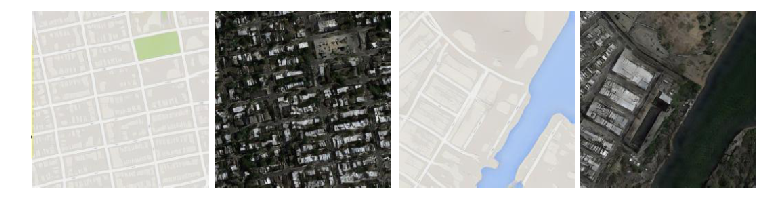

In [0]:
plt.figure(figsize=(13,10))
plt.imshow(plt.imread('CycleGAN/imgs/terrain-generation.png'))
plt.axis('off')


## Character/Hero Generation

We experimented with an image collection of Pokemon and another image collection of 8-bit low resolution heros.  By applying the encoder model on the low resolution collection, we expect to get high resolution, Pokemon-esque images.  For the reverse process, we expect to turn our Pokemon images into 8-bit renderings.  Of course this is simple enough to do without Deep Learning, so the first process is the more interesting one.  Interestingly, the colors tend to completely change.  Though, there are likely some extensions to the loss that we could add to help enforce that colors stay more constant, and these have been explored in the literature.

(-0.5, 1207.5, 643.5, -0.5)

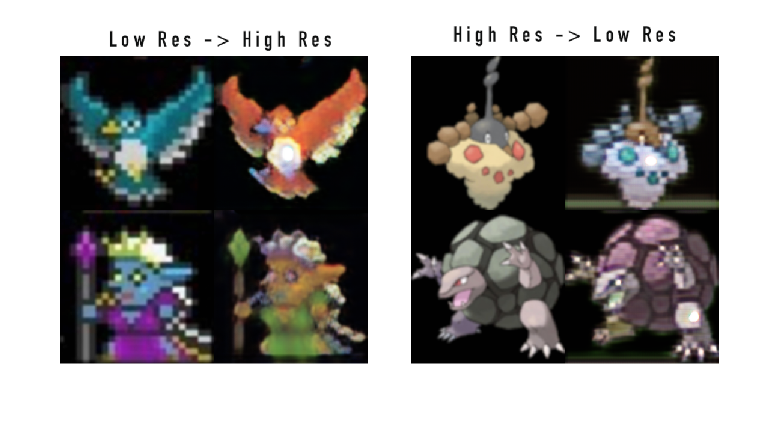

In [0]:
plt.figure(figsize=(13,10))
plt.imshow(plt.imread('CycleGAN/imgs/character-generation.png'))
plt.axis('off')

## Plenty More

The authors of the CycleGAN paper offer plenty more ideas on their GitHub along with their own implementation of CycleGAN using Torch and Pytorch: [https://junyanz.github.io/CycleGAN/](https://junyanz.github.io/CycleGAN/)

# Conclusion

Was this useful or did you make something awesome with CycleGAN?  Share it with me at https://twitter.com/pkmital - I'd love to hear!

Also, if you are interested in learning more about these networks and related techniques, including Seq2Seq, DRAW, MDN, WaveNet, and plenty more at https://www.kadenze.com/programs/creative-applications-of-deep-learning-with-tensorflow